In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
import pickle
import time
from sklearn.linear_model import LinearRegression
import random
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def load_data(filename):
    a_file = open(filename, "rb")
    output = pickle.load(a_file)
    a_file.close()
    
    return output

def save_data(filename, data):
    a_file = open(filename, "wb")
    pickle.dump(data, a_file)
    a_file.close()

In [3]:
train_data = load_data('Processed_Data/eventime_train_set.pkl')
test_data = load_data('Processed_Data/eventime_test_set.pkl')

In [16]:
input_dim = 100
X_lat = []
Y_lat = []
X_long = []
Y_long = []
for i, traj in enumerate(train_data):
    index = random.randint(0, len(train_data) - 1)
    traj = train_data[index]
    lat = traj[0]
    long = traj[1]
    
    if len(lat) > 2 * input_dim:
        for i in range(len(lat) - input_dim):
            X_lat.append(lat[i:i+input_dim])
            Y_lat.append(lat[i+input_dim])
            
            X_long.append(long[i:i+input_dim])
            Y_long.append(long[i+input_dim])
            
    if len(X_long) > 100000:
        break

In [17]:
X_lat = np.array(X_lat)
Y_lat = np.array(Y_lat)
X_long = np.array(X_long)
Y_long = np.array(Y_long)
print(X_lat.shape, Y_lat.shape)

(100157, 100) (100157,)


In [18]:
reg_lat = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg_lat.fit(X_lat, Y_lat)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
reg_long = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg_long.fit(X_long, Y_long)

0 0 0
0.7770771980931175
1.1274397184429956
0.41020808532453684
0.9053793817180728
1.1688568988586967
0.25144668729487285


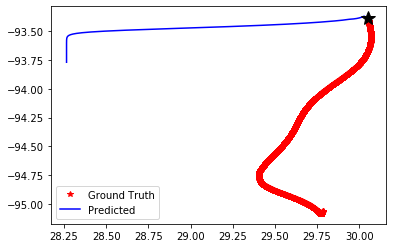

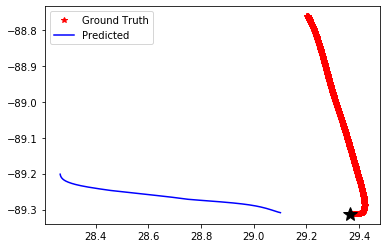

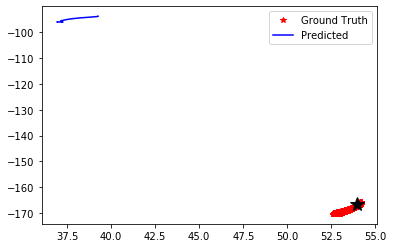

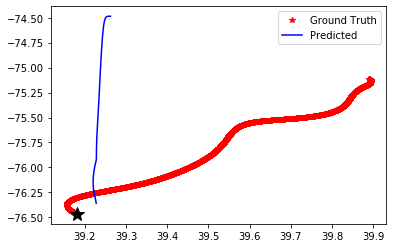

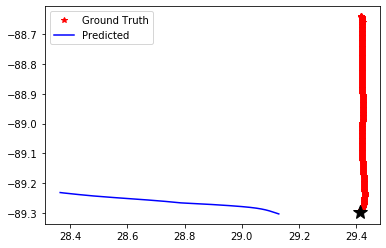

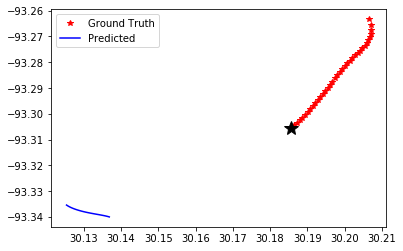

In [15]:
ratios = []
n_blowups = 0
success = 0
processed = 0
for k, _ in enumerate(test_data):
    if k%100 == 0:
        print(k, success, n_blowups)
    #index = random.randint(0, len(test_data) - 1)
    index = k
    traj = test_data[index]
    
    lat = traj[0]
    long = traj[1]
    pred_lat = []
    pred_long = []
    blowup = False
    
    if len(lat) > input_dim + 2:
        processed += 1
        
        #predicting latitude
        X = np.array(lat[:input_dim]).reshape(1,-1)
        for i in range(len(lat) - input_dim):
            pred_lat.append(reg_lat.predict(X)[0])
            X = list(np.squeeze(X, axis = 0))[1:] + [pred_lat[-1]]
            X = np.array(X).reshape(1,-1)
            
            if abs(pred_lat[-1]) > 360:
                blowup = True
                break
            
        if blowup == True:
            n_blowups += 1
            continue
            
        #predicting latitude
        X = np.array(long[:input_dim]).reshape(1,-1)
        for i in range(len(long) - input_dim):
            pred_long.append(reg_long.predict(X)[0])
            X = list(np.squeeze(X, axis = 0))[1:] + [pred_long[-1]]
            X = np.array(X).reshape(1,-1)
            
            if abs(pred_long[-1]) > 360:
                blowup = True
                break
                
        if blowup == True:
            n_blowups += 1
            continue
            
            
        #Grouping results    
        Y_lat = np.array(lat[input_dim:])
        Y_long = np.array(long[input_dim:])
        pred_lat = np.array(pred_lat)
        pred_long = np.array(pred_long)
        
        lat_diff = np.sum(np.abs(np.diff(Y_lat)))
        long_diff = np.sum(np.abs(np.diff(Y_long)))
        path_len = lat_diff + long_diff
        
        lat_diff = np.sum(np.abs(np.diff(pred_lat)))
        long_diff = np.sum(np.abs(np.diff(pred_long)))
        pred_len = lat_diff + long_diff
        
        ratios.append(pred_len/path_len)
        if ratios[-1] < 1.25:
            success += 1
            print(ratios[-1])
            plt.figure()
            plt.plot(Y_lat, Y_long, 'r*')
            plt.plot(pred_lat, pred_long, 'b')
            plt.legend(['Ground Truth', 'Predicted'])
            plt.plot(Y_lat[0],Y_long[0], 'k*', markersize=15)
        
    if k > 50:
        break

In [48]:
n_blowups/processed, success/processed, (processed - success - n_blowups) / processed

(0.24860111910471622, 0.5563549160671463, 0.1950439648281375)

In [41]:
n_blowups/len(test_data), success/len(test_data), (len(test_data) - success - n_blowups) / len(test_data),

(0.18734335839598998, 0.43295739348370926, 0.37969924812030076)

In [36]:
n_blowups/len(test_data), success/len(test_data), (len(test_data) - success - n_blowups) / len(test_data),

(0.18609022556390978, 0.44047619047619047, 0.37343358395989973)

In [ ]:
##### min(ratios), max(ratios)

In [146]:
def fit_curve(times, feature, degree = 3, delta = 30):
    z = np.polyfit(times, feature, degree)
    f = np.poly1d(z)
    
    x_new = np.linspace(times[0], times[-1], int((times[-1] + delta)/delta))
    y_new = f(x_new)
    
    return x_new, y_new

In [162]:
realtest_data = load_data('Processed_Data/test_set.pkl')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly conditioned
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RankWarning: Polyfit may be poorly cond

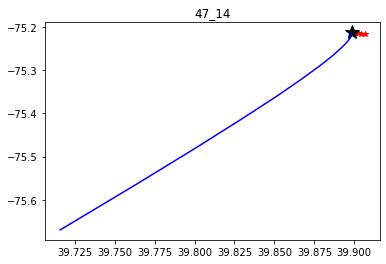

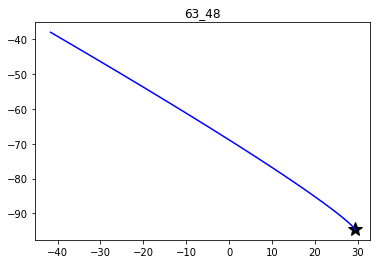

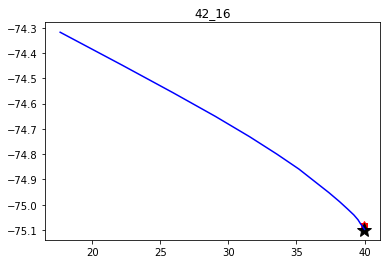

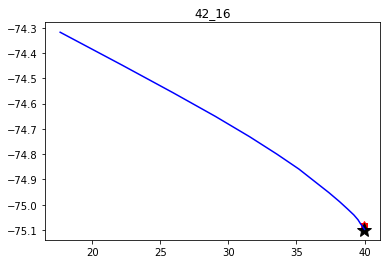

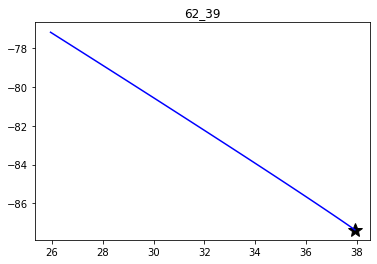

In [168]:
ratios = []
n_blowups = 0
success = 0
delta = 30
degree = 20
for k, _ in enumerate(realtest_data):
    #if k%100 == 0:
    #    print(k, success, n_blowups)
    index = random.randint(0, len(realtest_data) - 1)
    #index = k
    traj = realtest_data[index]
    
    lat = traj[0]
    long = traj[1]
    datetime = traj[2]
    time_diff = np.array([0] + [t.seconds for t in np.diff(np.array(datetime))])
    times = np.cumsum(time_diff)
    for t, time in enumerate(times):
        if time > input_dim * delta:
            break

    query_times = times[:t+1]
    n_iterations = int((times[-1] - times[t])/delta)
    
    pred_lat = []
    pred_long = []
    blowup = False
    
    if len(lat) > t+1:
        #initializing prediction for lat
        real_input = np.array(lat[:t+1])
        _, X = fit_curve(query_times, real_input, degree = degree, delta = delta)
        X = X[-input_dim:]
        X = X.reshape(1,-1)
        
        for i in range(n_iterations):
            pred_lat.append(reg_lat.predict(X)[0])
            X = list(np.squeeze(X, axis = 0))[1:] + [pred_lat[-1]]
            X = np.array(X).reshape(1,-1)
            
            if abs(pred_lat[-1]) > 360:
                blowup = True
                break
            
        if blowup == True:
            n_blowups += 1
            continue
            
        #initializing prediction for long
        real_input = np.array(long[:t+1])
        _, X = fit_curve(query_times, real_input, degree = degree, delta = delta)
        X = X[-input_dim:]
        X = X.reshape(1,-1)
        
        for i in range(n_iterations):
            pred_long.append(reg_long.predict(X)[0])
            X = list(np.squeeze(X, axis = 0))[1:] + [pred_long[-1]]
            X = np.array(X).reshape(1,-1)
            
            if abs(pred_long[-1]) > 360:
                blowup = True
                break
                
        if blowup == True:
            n_blowups += 1
            continue
            
            
        #Grouping results, can't calculate error. See non-blown up results through visualization    
        Y_lat = np.array(lat[t+1:])
        Y_long = np.array(long[t+1:])
        pred_lat = np.array(pred_lat)
        pred_long = np.array(pred_long)
        
        plt.figure()
        plt.plot(Y_lat, Y_long, 'r*')
        plt.plot(Y_lat[0],Y_long[0], 'k*', markersize=15)
        plt.plot(pred_lat, pred_long, 'b')
        plt.title(str(len(lat)) + '_' + str(n_iterations))
        
    if k > 30:
        break